## motion of a damped harmonic oscillator


In [4]:
!pip install numpy matplotlib scipy scikit-learn torch

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 5.5 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 9.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 9.7 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.2 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 9.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

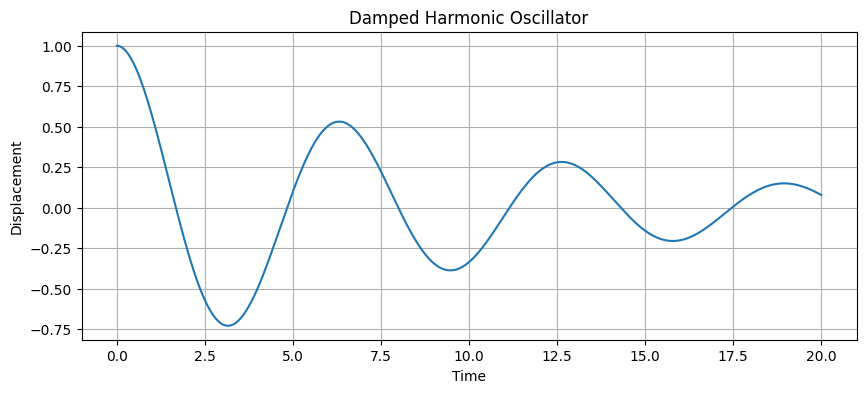

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Damped oscillator function (m * x'' + c * x' + k * x = 0)
def damped_oscillator(t, y, m=1.0, c=0.2, k=1.0):
    x, v = y
    dxdt = v
    dvdt = -(c/m)*v - (k/m)*x
    return [dxdt, dvdt]

# Solve the ODE
t_span = (0, 20)
t_eval = np.linspace(*t_span, 1000)
y0 = [1.0, 0.0]  # initial position and velocity

sol = solve_ivp(damped_oscillator, t_span, y0, t_eval=t_eval)
x = sol.y[0]
t = sol.t

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(t, x)
plt.title("Damped Harmonic Oscillator")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.grid(True)
plt.show()


In [5]:
import matplotlib.pyplot as plt


In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch

# Normalize the displacement values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1))

# Create sliding windows of data
window_size = 20
X = []
y = []

for i in range(len(x_scaled) - window_size):
    X.append(x_scaled[i:i+window_size])
    y.append(x_scaled[i+window_size])

X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Reshape input for LSTM: [samples, time_steps, features]
X_tensor = X_tensor.view(-1, window_size, 1)
y_tensor = y_tensor.view(-1, 1)


In [7]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, seq_len, hidden]
        out = self.fc(out[:, -1, :])  # get output from last time step
        return out

# Create the model
model = LSTMModel()


In [8]:
import torch.optim as optim

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.030238
Epoch 20, Loss: 0.010047
Epoch 30, Loss: 0.001673
Epoch 40, Loss: 0.001192
Epoch 50, Loss: 0.000351
Epoch 60, Loss: 0.000304
Epoch 70, Loss: 0.000214
Epoch 80, Loss: 0.000156
Epoch 90, Loss: 0.000136
Epoch 100, Loss: 0.000125


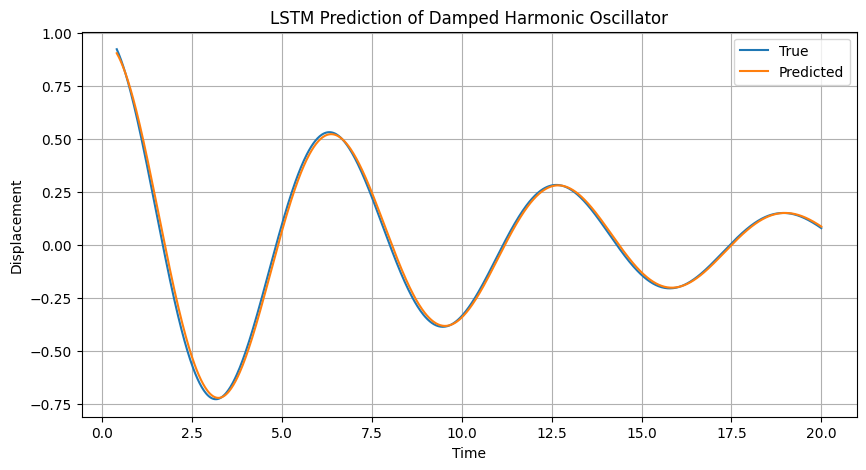

In [9]:
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

# Inverse transform to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_true_rescaled = scaler.inverse_transform(y_tensor.numpy())


plt.figure(figsize=(10, 5))
plt.plot(t[window_size:], y_true_rescaled, label='True')
plt.plot(t[window_size:], predictions_rescaled, label='Predicted')
plt.title("LSTM Prediction of Damped Harmonic Oscillator")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()
plt.grid(True)
plt.show()
